# A Weekend Article Prediction Model

Mashable is an online news source that covers digital culture, social media and technology, similar to The Verge and TechCrunch. The dataset we are looking at contains information about articles published by Mashable in a period of two years. The original goal of the dataset that was collected by UC Irvine was to predict the number of shares in social networks (popularity) for each article published on Mashable. For our project, **we will create a model that can be used to determine whether an article by Mashable was published on a weekday or weekend**. We will do this by first determining what variables are the most important for the categorization of weekday vs. weekend. The online news popularity data set was collected from Mashable and summarizes two years of articles using 61 attributes.

### Methods

Our goal is to use K-nearest neighbours classification to make a model and predict whether future articles were published on weekends. In particular we can use cross-validation with a C value of 5 (as a balance computation time and accuracy) to tune our K value. First, before doing anything, we load the tidyverse, tidymodels, and GGaly libraries, and then we load in the data and determine what aspects need cleaning.

In [1]:
library(tidyverse)
library(tidymodels)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
options(repr.matrix.max.rows = 6)
news_data <- read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQqn7Dsf5KqcPHqcwKBwVpLiEczGNRusJeqmw_xhNsheA8anlCokXI7jDfOGfGKwjIENuB7ngwYsAiQ/pub?gid=1905386087&single=true&output=csv")
head(news_data)

Parsed with column specification:
cols(
  .default = col_double(),
  url = col_character()
)

See spec(...) for full column specifications.



url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,⋯,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
http://mashable.com/2013/01/07/amazon-instant-video-browser/,731,12,219,0.6635945,1,0.8153846,4,2,1,⋯,0.10000000,0.7,-0.3500000,-0.600,-0.2000000,0.5000000,-0.1875000,0.00000000,0.1875000,593
http://mashable.com/2013/01/07/ap-samsung-sponsored-tweets/,731,9,255,0.6047431,1,0.7919463,3,1,1,⋯,0.03333333,0.7,-0.1187500,-0.125,-0.1000000,0.0000000,0.0000000,0.50000000,0.0000000,711
http://mashable.com/2013/01/07/apple-40-billion-app-downloads/,731,9,211,0.5751295,1,0.6638655,3,1,1,⋯,0.10000000,1.0,-0.4666667,-0.800,-0.1333333,0.0000000,0.0000000,0.50000000,0.0000000,1500
http://mashable.com/2013/01/07/astronaut-notre-dame-bcs/,731,9,531,0.5037879,1,0.6656347,9,0,1,⋯,0.13636364,0.8,-0.3696970,-0.600,-0.1666667,0.0000000,0.0000000,0.50000000,0.0000000,1200
http://mashable.com/2013/01/07/att-u-verse-apps/,731,13,1072,0.4156456,1,0.5408895,19,19,20,⋯,0.03333333,1.0,-0.2201923,-0.500,-0.0500000,0.4545455,0.1363636,0.04545455,0.1363636,505
http://mashable.com/2013/01/07/beewi-smart-toys/,731,10,370,0.5598886,1,0.6981982,2,2,0,⋯,0.13636364,0.6,-0.1950000,-0.400,-0.1000000,0.6428571,0.2142857,0.14285714,0.2142857,855


**Table 1.** Preview of our entire data set.

Seeing that the data set contains data that is non-numeric and also contains publication date related variables, we start by removing those. We also transform the target variable (is_weekend) column to contain the factors Weekday and Weekend instead of 0 and 1 respectively to make the downstream analysis easier to understand.

In [3]:
# Here we load and clean the dataset. 
# We remove all non-numeric and publication date related variables.
news_data_clean <- news_data %>%
    filter(!is.na(is_weekend)) %>%
    select(-c(weekday_is_monday, weekday_is_tuesday, weekday_is_wednesday, weekday_is_thursday, weekday_is_friday, weekday_is_saturday, weekday_is_sunday)) %>%
    select(-c(data_channel_is_lifestyle, data_channel_is_entertainment, data_channel_is_bus, data_channel_is_socmed, data_channel_is_tech, data_channel_is_world)) %>%
    select(-c(url, timedelta))

# We also transform the is_weekend column to contain the factors Weekday and Weekend instead of 0 and 1 respectively.
news_data_clean$is_weekend <- as.character(news_data_clean$is_weekend)
news_data_clean$is_weekend[news_data_clean$is_weekend == "0"] <- "Weekday"
news_data_clean$is_weekend[news_data_clean$is_weekend == "1"] <- "Weekend"
news_data_clean$is_weekend <- as.factor(news_data_clean$is_weekend)

news_data_clean

n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,⋯,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12,219,0.6635945,1,0.8153846,4,2,1,0,4.680365,⋯,0.10000000,0.7,-0.3500000,-0.600,-0.2000000,0.5,-0.1875,0.0,0.1875,593
9,255,0.6047431,1,0.7919463,3,1,1,0,4.913725,⋯,0.03333333,0.7,-0.1187500,-0.125,-0.1000000,0.0,0.0000,0.5,0.0000,711
9,211,0.5751295,1,0.6638655,3,1,1,0,4.393365,⋯,0.10000000,1.0,-0.4666667,-0.800,-0.1333333,0.0,0.0000,0.5,0.0000,1500
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
10,442,0.5163551,1,0.6441281,24,1,12,1,5.076923,⋯,0.1363636,0.5,-0.3564394,-0.8,-0.1666667,0.4545455,0.1363636,0.04545455,0.1363636,1900
6,682,0.5394933,1,0.6926605,10,1,1,0,4.975073,⋯,0.0625000,0.5,-0.2052455,-0.5,-0.0125000,0.0000000,0.0000000,0.50000000,0.0000000,1100
10,157,0.7019868,1,0.8461538,1,1,0,2,4.471338,⋯,0.1000000,0.5,-0.2000000,-0.2,-0.2000000,0.3333333,0.2500000,0.16666667,0.2500000,1300


**Table 2.** Preview of our cleaned data set.

Next we separate the data into training and testing sets. We split the data 50/50 because we have just about 40,000 observations and so we are confident that our model would be sufficiently trained given 20,000 observations.

In [4]:
# Here we separate the data into a training and testing set. 
set.seed(1)
news_split <- initial_split(news_data_clean, prop = 0.5, strata = is_weekend)
news_train <- training(news_split)
news_test <- testing(news_split)

To determine which variables we want to use as our predictors, we want to find the top 5 variables which have the largest mean differences between whether the article was published on a weekend vs. weekday. We begin by scaling all the numeric variables. Then we group the data by whether they were weekday or weekend articles and calculate their means. We pivot the dataframe for ease of interpretation, calculate the mean difference between each of the variables, take the absolute value of the differences, and arrange them in decreasing order so that we can take the top 5.

In [5]:
# Scaling all variables other than is_weekend, then adding it back
news_train_scaled <- select(news_train, -is_weekend) %>%
    scale(center = FALSE) %>%
    data.frame(is_weekend = news_train$is_weekend)

# Table of differences between the weekend vs weekday metrics using the scaled data
news_table_scaled <- group_by(news_train_scaled, is_weekend) %>%
    summarize_all(mean, na.rm = TRUE) %>%
    pivot_longer(cols = n_tokens_title:shares,
                names_to = "variables",
                values_to = "values") %>%
    pivot_wider(names_from = "is_weekend",
               values_from = "values") %>%
    mutate(scaled_mean_diff = abs(Weekday-Weekend)) %>%
    arrange(desc(scaled_mean_diff))
slice(news_table_scaled, 1:5)

variables,Weekday,Weekend,scaled_mean_diff
<chr>,<dbl>,<dbl>,<dbl>
num_hrefs,0.6836021,0.8383238,0.15472166
num_imgs,0.4613575,0.5887637,0.12740614
num_self_hrefs,0.6429533,0.7501674,0.10721405
n_tokens_content,0.7404440,0.8428253,0.10238132
title_sentiment_polarity,0.2485305,0.3481088,0.09957828


**Table 3.** Here we show the top 5 scaled mean differences between weekday and weekend articles calculated from our training set.

From the table we now have our 5 predictor variables:
The variables chosen are:
- num_hrefs, number of links in the article
- num_imgs, number of images
- num_self_hrefs, number of links to other articles published by Mashable
- n_tokens_content, number of words in the content 
- title_sentiment_polarity, title polarity (how positive or negative the title was worded)

Next we want to perform some exploratory data analysis. We use `ggpairs()` to see how the top 5 variables relate to each other, their distributions and each of their correlation coefficients.

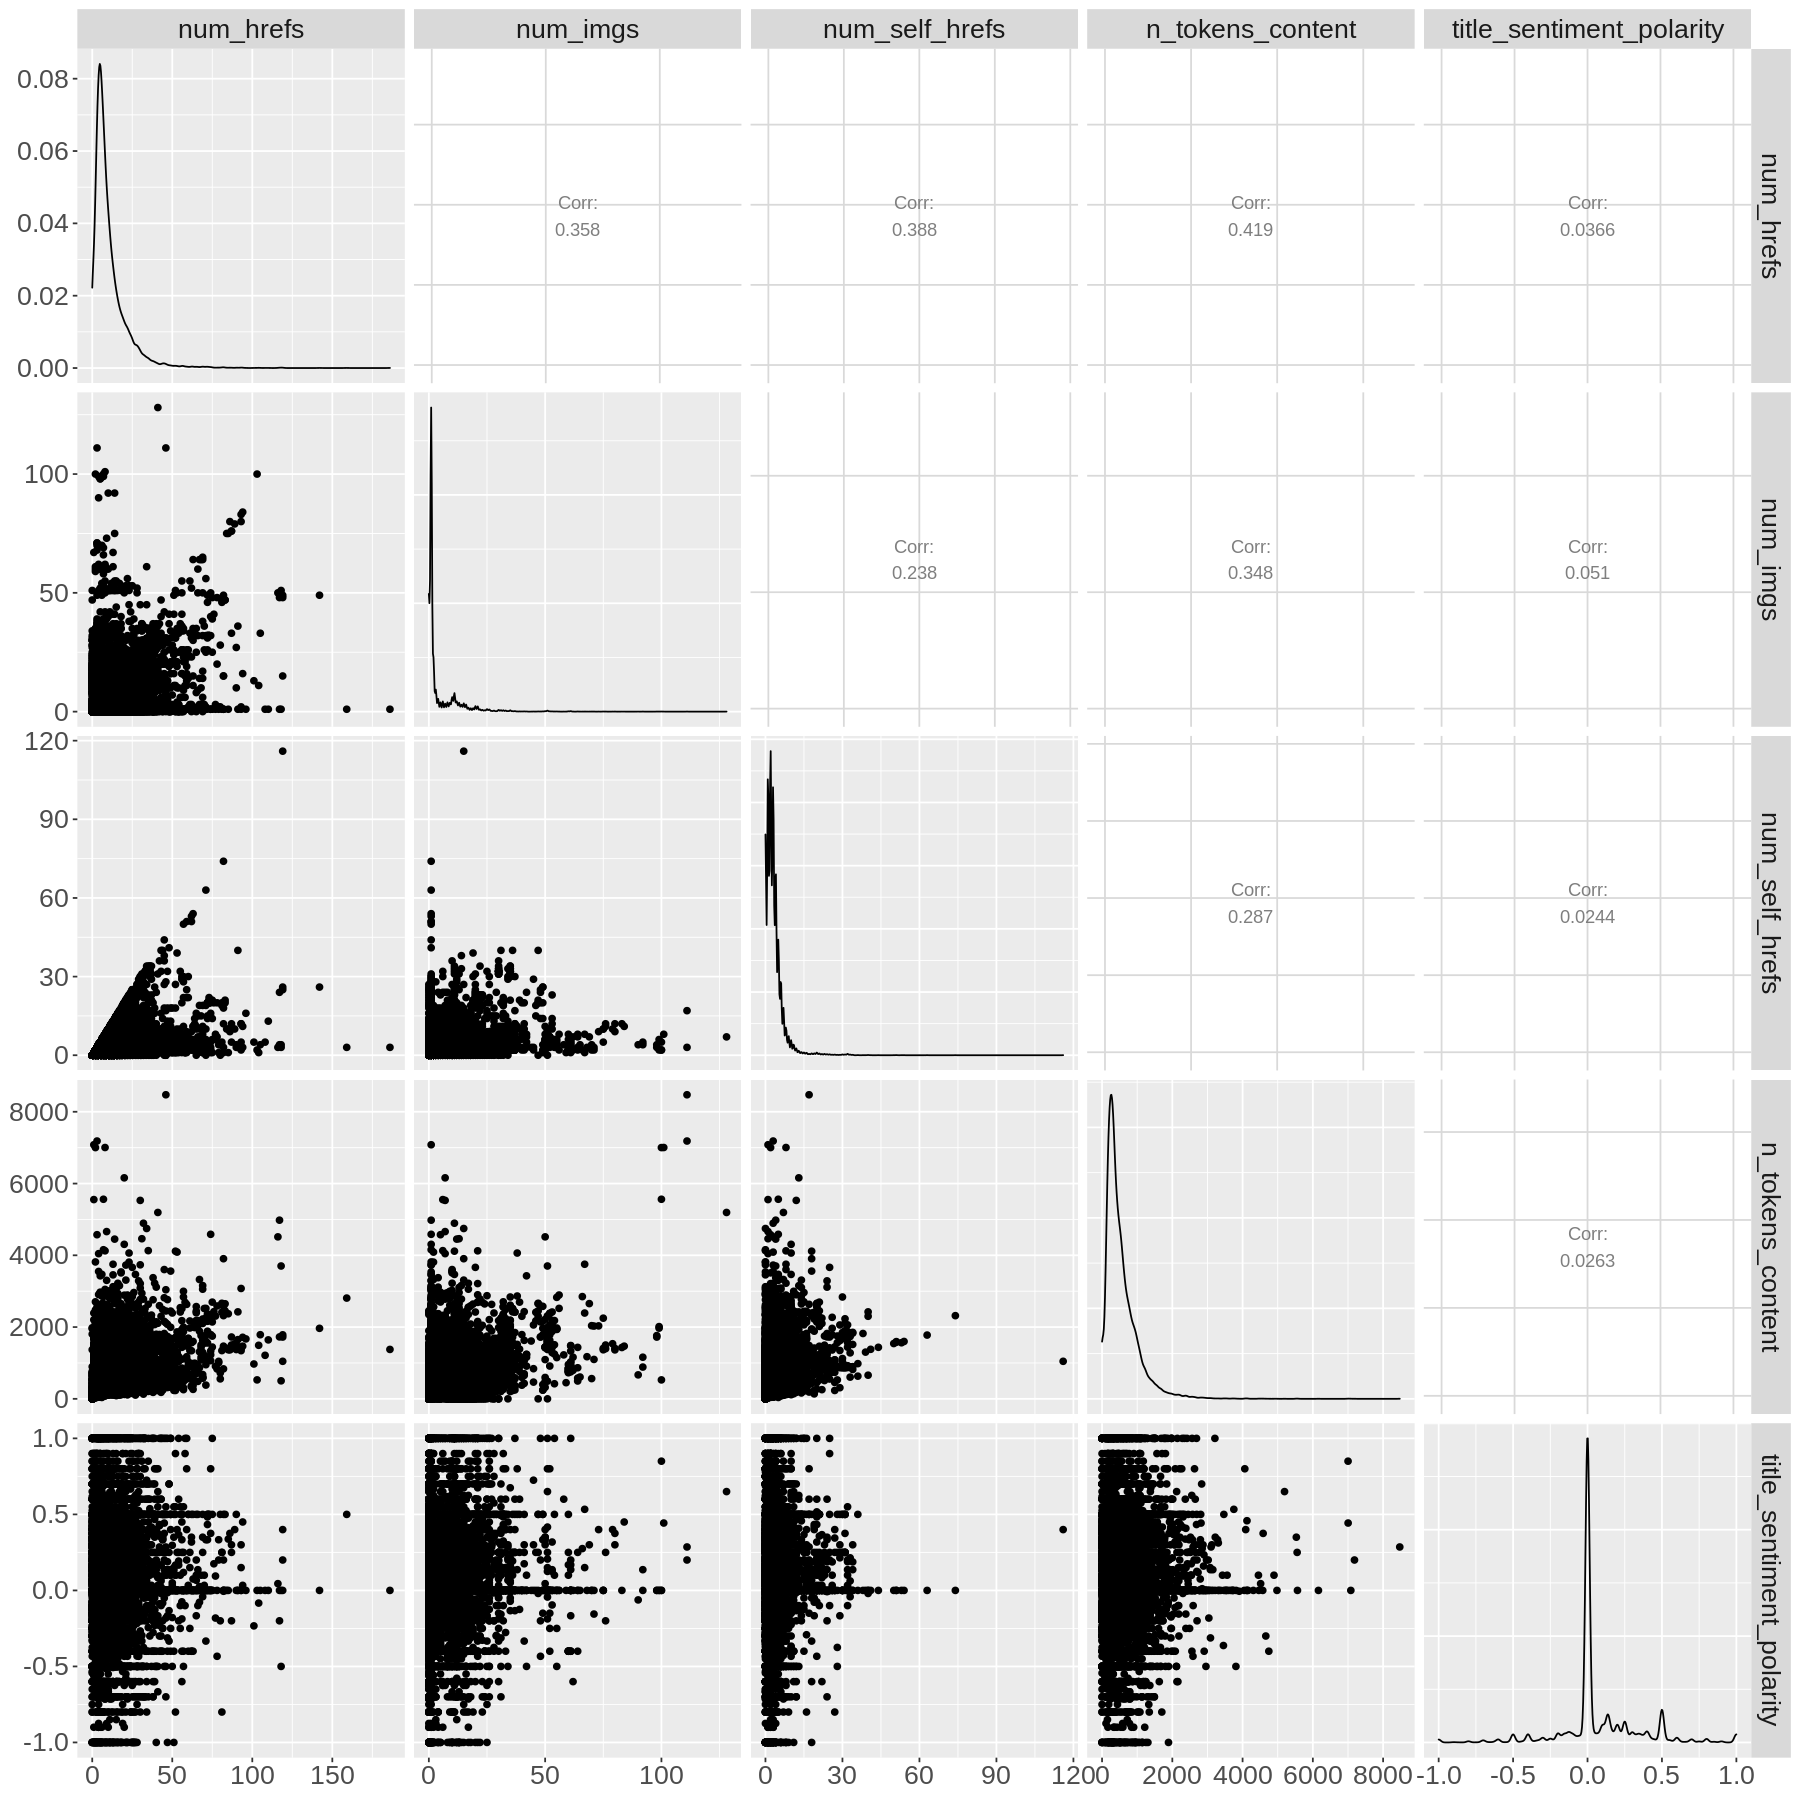

In [6]:
options(repr.plot.width = 15, repr.plot.height = 15) 

plot_pairs <- news_train %>%
    select(num_hrefs, num_imgs, num_self_hrefs, n_tokens_content, title_sentiment_polarity) %>%
    ggpairs() +
    theme(text = element_text(size = 20))
plot_pairs

**Figure 1.** Here we show a plot for our top 5 scaled mean differences variables using our training data. Scatterplots between the variables are shown on the lower left, distributions are on the diagonal, and correlation coefficients are shown on the top right.

Now, we move on to cross-validation to choose the best possible k value for our model. We split the training data into 5 folds, and also set up the recipe for use.

In [7]:
set.seed(1)
# Perform cross validation to find best k value 
news_vfold <- vfold_cv(news_train, v = 5, strata = is_weekend)

news_recipe <- recipe(is_weekend ~ 
                      num_hrefs + 
                      num_imgs + 
                      num_self_hrefs + 
                      n_tokens_content + 
                      title_sentiment_polarity,
                      data = news_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

We then set up a model specification but give it the `tune()` argument to specify that we intend to tune the model as part of the cross-validation.

In [8]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

We perform the cross-validation step here, using the `tune_grid()` function to fit the `news_vfold` model using 10 different k values. We also collect the results of this cross-validation using `collect_metrics()`.

In [9]:
set.seed(1)
knn_result <- workflow() %>%
    add_recipe(news_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = news_vfold, grid = 10) %>%
    collect_metrics

Using the results, we can filter for the accuracy of each model with their respective k values, and plot the results into a graph. We can use the graph to determine which k value to use.

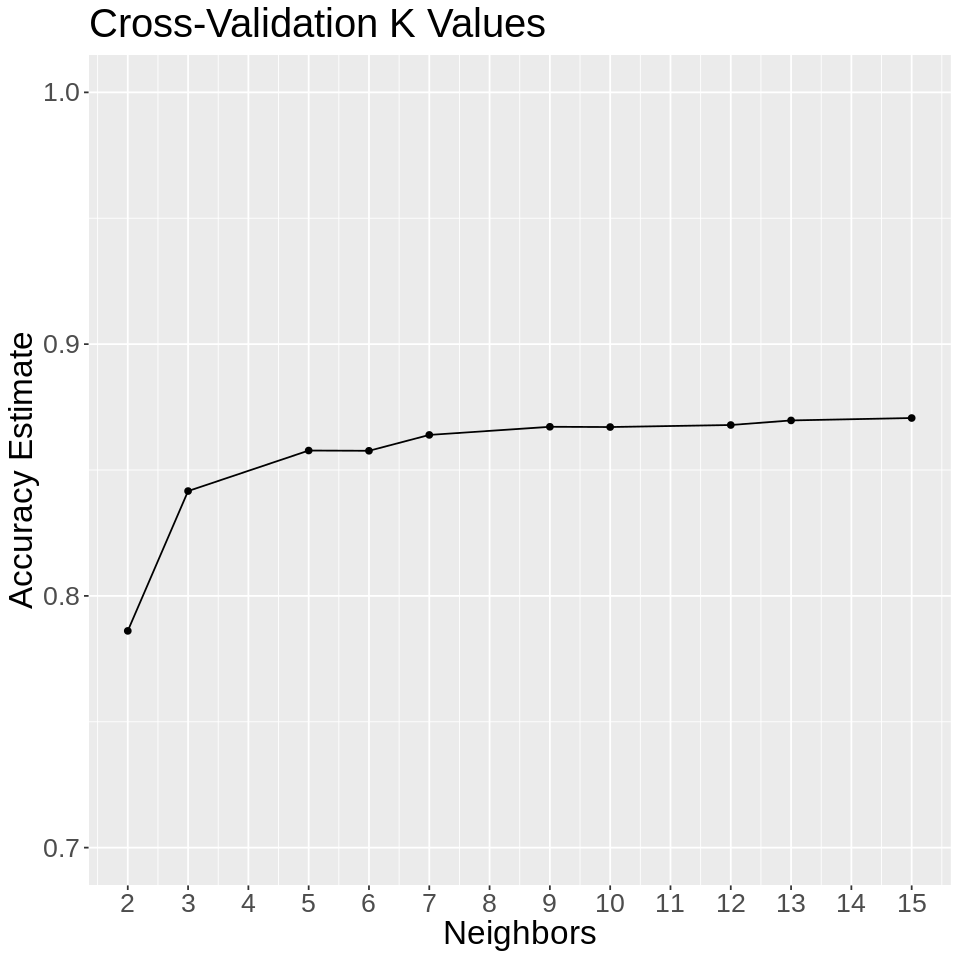

In [10]:
accuracies <- knn_result %>%
    filter(.metric == "accuracy")

# Visualize the best k value to pick
options(repr.plot.width = 8, repr.plot.height = 8)
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Cross-Validation K Values",
         x = "Neighbors",
         y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 16, by = 1)) +
    scale_y_continuous(limits = c(0.7, 1.0)) +
    theme(text = element_text(size = 20))

cross_val_plot

**Figure 2.** A plot showing the accuracy estimates per K value resulting from our cross-validation.

Now we finalize our model specification using k = 9 for our neighbors and fit the model to our full training data set.

In [11]:
# Pick k = 9 because accuracy doesn't change much between 8-10
news_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) %>%
    set_engine("kknn") %>%
    set_mode("classification")

news_fit <- workflow() %>%
    add_recipe(news_recipe) %>%
    add_model(news_spec) %>%
    fit(news_train)

Finally we use our model to classify articles in our testing data set and bind their results in another column which we use for measuring our model's accuracy.

In [12]:
news_test_predictions <- predict(news_fit, news_test) %>%
    bind_cols(news_test) 

In [13]:
news_test_accuracy <- news_test_predictions %>%
    metrics(truth = is_weekend, estimate = .pred_class)

news_test_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.86873171
kap,binary,0.08785647


**Table 4.** Metrics table showing our model's accuracy at 86.8%.

In [14]:
news_test_mat <- news_test_predictions %>%
    conf_mat(truth = is_weekend, estimate = .pred_class)

news_test_mat

          Truth
Prediction Weekday Weekend
   Weekday   17049    2424
   Weekend     178     171

**Figure 3.** Confusion maxtrix showing the statistics of our model's predictions. Our model correctly predicted 17049 weekdays as weekdays, and 171 weekends as weekends. Our model also incorrectly predicted 178 weekdays as weekends, and 2424 weekends as weekdays.

To visualize our analysis, we can plot the results of our confusion matrix. Using the predictions, we select out only the true target variable and our predicted classification, and then use a bar plot to generate the proportions of our model's predictions vs. the true type of day.

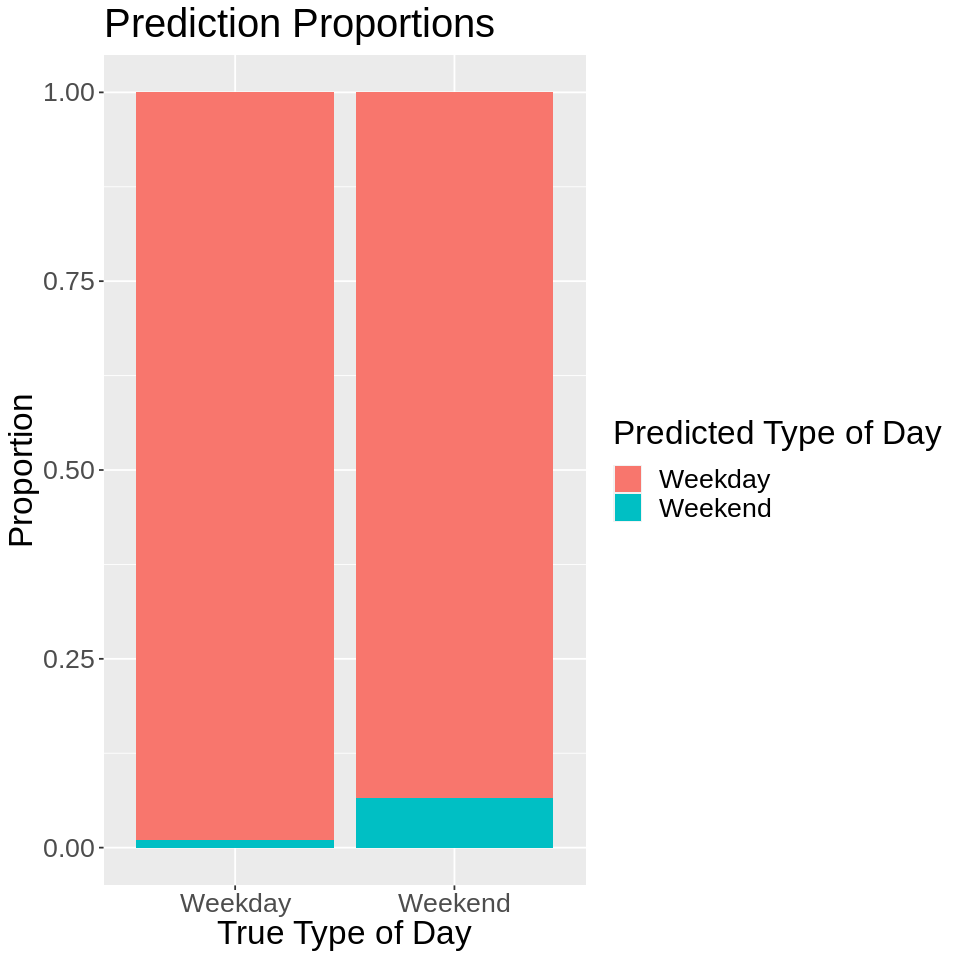

In [15]:
news_proportion <- news_test_predictions %>%
    select(.pred_class, is_weekend)

options(repr.plot.width = 8, repr.plot.height = 8)
proportion_plot <- ggplot(news_proportion, aes(x = is_weekend, fill = .pred_class)) +
    geom_bar(position = "fill") +
    labs(title = "Prediction Proportions",
        x = "True Type of Day",
        y = "Proportion",
        fill = "Predicted Type of Day") +
    theme(text = element_text(size = 20))
proportion_plot

**Figure 4.** A bar plot showing the proportions of our model's predictions mapped onto the true classifications.